In [1]:
import numpy as np
np.random.seed(42)

In [ ]:
from matplotlib import pyplot as plt
import torchvision.transforms as transforms

!pip install timm

from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

labels = ['resnet101', 'resnet152', 'alexnet', 'densenet121', 'googlenet', 'mobilenet_v2', 'inception_v3', 'resnext50_32x4d', 'resnext101_32x8d_wsl', 'deit_base_patch16_224']

import torch
# models = [torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)]
# , torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True),
#           torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True), torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True),
#           torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True), torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True),
#           torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True), torch.hub.load('pytorch/vision:v0.10.0', 'resnext50_32x4d', pretrained=True),
#           torch.hub.load('facebookresearch/WSL-Images', 'resnext101_32x8d_wsl'), torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)]

models = [torch.hub.load('facebookresearch/WSL-Images', 'resnext101_32x8d_wsl')]
labels = ['resnext101_32x8d_wsl']

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Using cache found in /root/.cache/torch/hub/facebookresearch_WSL-Images_main


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !unzip /content/drive/MyDrive/D2O.zip
!unzip /content/drive/MyDrive/imagenet-a.zip
# !unzip /content/drive/MyDrive/imagenet-a-isolated.zip


Archive:  /content/drive/MyDrive/imagenet-a.zip
replace __MACOSX/._imagenet-a? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# !mv NewD2I/ D2O 
!ls

drive  imagenet-a  __MACOSX  sample_data


In [ ]:
!ls D2O
!ls D2O/acorn | wc -l


ls: cannot access 'D2O': No such file or directory
ls: cannot access 'D2O/acorn': No such file or directory
0


In [ ]:
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

--2022-08-18 21:35:21--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt.1’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2022-08-18 21:35:21 (54.4 MB/s) - ‘imagenet_classes.txt.1’ saved [10472/10472]



In [ ]:
# !cat imagenet_classes.txt

In [ ]:
from PIL import Image
import os 
from collections import defaultdict
import numpy as np


# Read the categories
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]


perfs = {} # perf['resnet']['cat']['img_name'] = [(), (), (), (), ()]
perfs_acc = {}
prob_top1 = {}

import numpy as np

In [ ]:
# Run the models
which_db = 'D2O' #'imagenet-a'

for idx_m, model in enumerate(models):
  perfs[idx_m] = {}
  prob_top1[idx_m] = {}

  model.eval()

  if idx_m == len(models)-1: # only for Deit
    preprocess = transforms.Compose([
      transforms.Resize(256, interpolation=3),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
    ])
  else:
    preprocess = transforms.Compose([
        transforms.Resize(256, interpolation=3),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
    ])


  dirs = os.listdir(f'{which_db}/')
      
  accs = {}

  for folder in dirs:
    folder_corrected = folder #.replace('_', ' ')
    print(f'{labels[idx_m]}: {folder}')
    
    if '.' in folder or folder in ['person', 'face', 'miscellaneous', 'cow', 'car', 'cat', 'giraffe']: continue

    perfs[idx_m][folder] = {}
    prob_top1[idx_m][folder] = {}


    indir = os.path.join(f'{which_db}/', folder)    
    files = os.listdir(indir)    

    model.to('cuda')

    count_t1 = count_t5 = 0

    for idx, f in enumerate(files):
      if f == '.DS_Store': continue

      filename = os.path.join(indir, f)
      input_image = Image.open(filename)
      input_image = input_image.convert('RGB')

      input_tensor = preprocess(input_image)
      input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

      input_batch = input_batch.to('cuda')
          

      with torch.no_grad():
          output = model(input_batch)
      probabilities = torch.nn.functional.softmax(output[0], dim=0)


      top5_prob, top5_catid = torch.topk(probabilities, 5)
      top1_prob, top1_catid = torch.topk(probabilities, 1)  

      cls_t1 = []
      for j in categories[top1_catid].split(','):
        cls_t1.append(j.lower())
        cls_t1.extend(j.split(' '))

      cls_t5 = []
      for n in top5_catid:
        for j in categories[n].lower().split(','):
          cls_t5.append(j)
          cls_t5.extend(j.split(' '))


      perfs[idx_m][folder][f] = (categories[top1_catid].lower(), [categories[n].lower() for n in top5_catid])  
      prob_top1[idx_m][folder][f] = top1_prob

      count_t1 = count_t1 + 1 if folder_corrected.lower() in cls_t1  else count_t1
      count_t5 = count_t5 + 1 if folder_corrected.lower() in cls_t5 else count_t5

    accs[folder.lower()] = [count_t1*100/len(files), count_t5*100/len(files)]

  perfs_acc[idx_m] = accs

# with open(f'/content/drive/MyDrive/results_{which_db}.npy', 'wb') as f:
#   np.save(f, [perfs, perfs_acc])


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "


resnext101_32x8d_wsl: banana


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


resnext101_32x8d_wsl: mouse
resnext101_32x8d_wsl: kite
resnext101_32x8d_wsl: basketball
resnext101_32x8d_wsl: toaster
resnext101_32x8d_wsl: giraffe
resnext101_32x8d_wsl: syringe
resnext101_32x8d_wsl: mushroom
resnext101_32x8d_wsl: spatula
resnext101_32x8d_wsl: vase
resnext101_32x8d_wsl: teddy
resnext101_32x8d_wsl: sock
resnext101_32x8d_wsl: tractor
resnext101_32x8d_wsl: cat
resnext101_32x8d_wsl: bagel
resnext101_32x8d_wsl: elephant
resnext101_32x8d_wsl: umbrella
resnext101_32x8d_wsl: clock
resnext101_32x8d_wsl: pillow
resnext101_32x8d_wsl: .DS_Store
resnext101_32x8d_wsl: bicycle-built-for-two
resnext101_32x8d_wsl: pill bottle
resnext101_32x8d_wsl: sunglass
resnext101_32x8d_wsl: turtle
resnext101_32x8d_wsl: bell pepper
resnext101_32x8d_wsl: squirrel
resnext101_32x8d_wsl: cow
resnext101_32x8d_wsl: car
resnext101_32x8d_wsl: toilet seat
resnext101_32x8d_wsl: pizza
resnext101_32x8d_wsl: rabbit
resnext101_32x8d_wsl: miscellaneous
resnext101_32x8d_wsl: pretzel
resnext101_32x8d_wsl: person
res

In [ ]:
# with open('/content/drive/MyDrive/results.npy', 'r') as f:
# a,b = np.load('/content/drive/MyDrive/resultsD2O.npy', allow_pickle=True)

In [ ]:
dirs = os.listdir(f'{which_db}/')
if '.DS_Store' in dirs:
  dirs.remove('.DS_Store')
# dirs.remove('.ipynb_checkpoints')
for i in ['person', 'face', 'miscellaneous', 'cow', 'car', 'cat', 'giraffe']:
  if i in dirs:
    dirs.remove(i)  

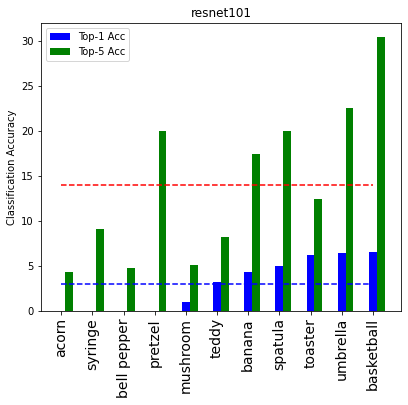

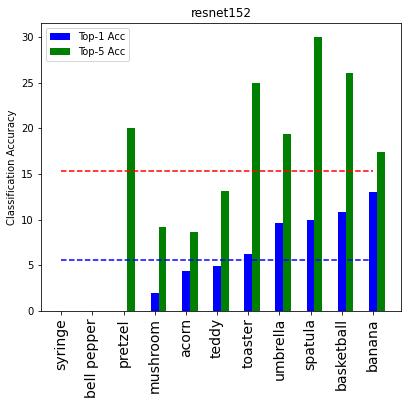

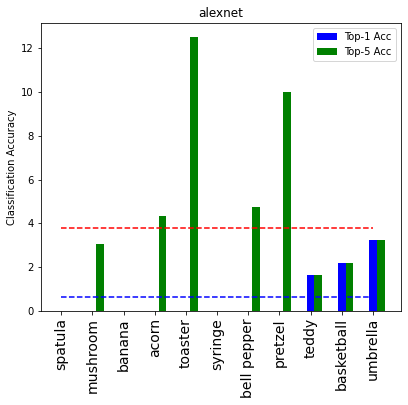

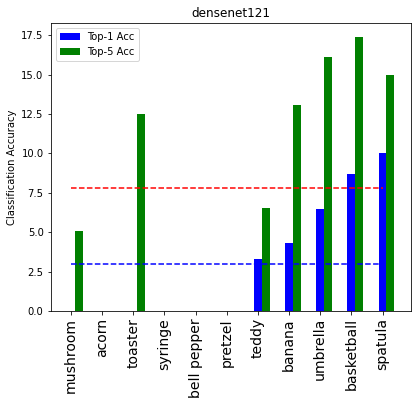

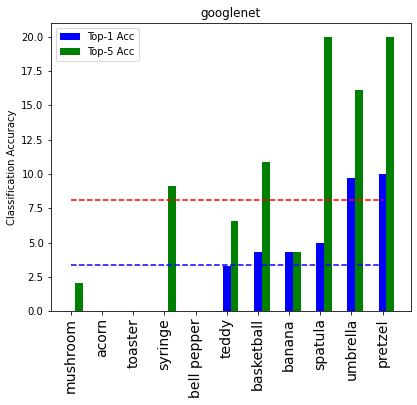

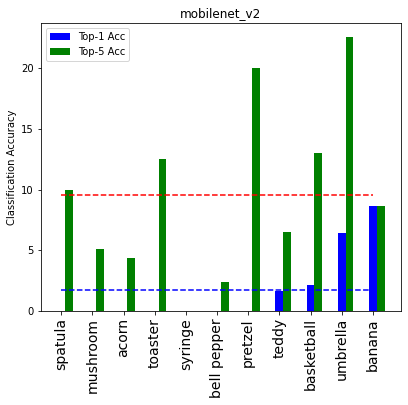

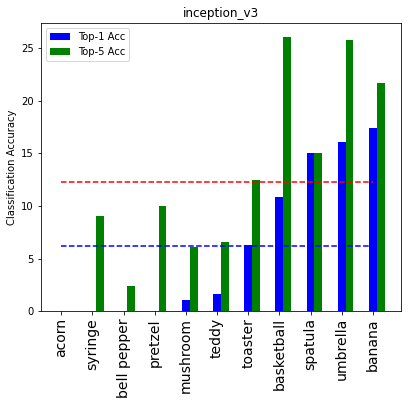

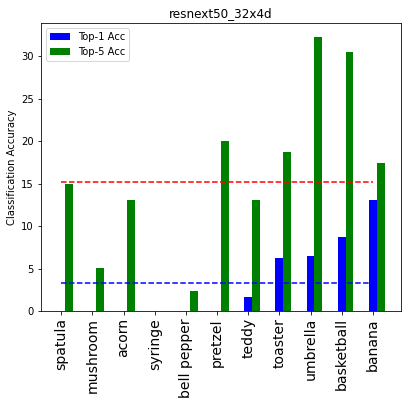

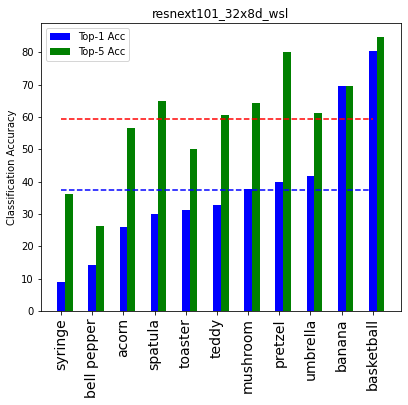

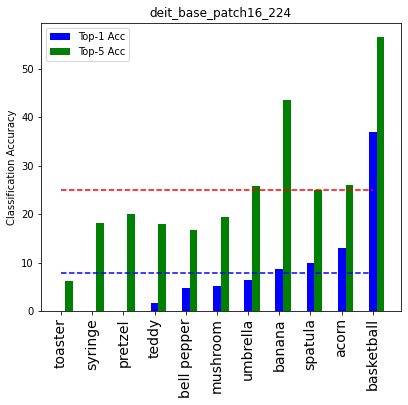

In [ ]:
avgs_all = np.zeros((10,2))
num_classes = len(dirs)
X = np.arange(num_classes)

# cat_labels = [str(i) for i in range(29)]

for i in range(10):
  a = np.array(list(perfs_acc[i].values()))
  avgs = a
  avgs_all[i,:] = np.mean(a, axis=0)

  sortIdx = np.argsort(avgs,axis=0)[:,0]
  avgs = avgs[sortIdx]  

  fig = plt.figure(figsize=(5,4))

  ax = fig.add_axes([0,0,1,1])

  ax.bar(X + 0.00, avgs[:,0], color = 'b', width = 0.25)
  ax.bar(X + 0.25, avgs[:,1], color = 'g', width = 0.25)



  ax.set_ylabel('Classification Accuracy')
  ax.set_title(labels[i])
  ax.set_xticks(X)
  ax.set_xticklabels(np.array(dirs)[sortIdx], rotation=90, fontsize=14)
  # ax.set_yticks(np.arange(0, 81, 10))
  ax.legend(labels=['Top-1 Acc', 'Top-5 Acc'])

  ax.plot(np.arange(num_classes), [avgs.mean(axis=0)[0]]*num_classes, color = 'b', linestyle='--')
  ax.plot(np.arange(num_classes), [avgs.mean(axis=0)[1]]*num_classes, color = 'r', linestyle='--')


  # plt.plot(a)
  plt.show()

In [ ]:
avgs_all

array([[ 2.9882068 , 14.03692129],
       [ 5.55883073, 15.34792539],
       [ 0.63991489,  3.79181992],
       [ 2.97943452,  7.79302116],
       [ 3.33197819,  8.09413873],
       [ 1.72368385,  9.56436108],
       [ 6.20905948, 12.29856601],
       [ 3.28000796, 15.22503428],
       [37.56282282, 59.51413203],
       [ 7.87732317, 25.03749409]])

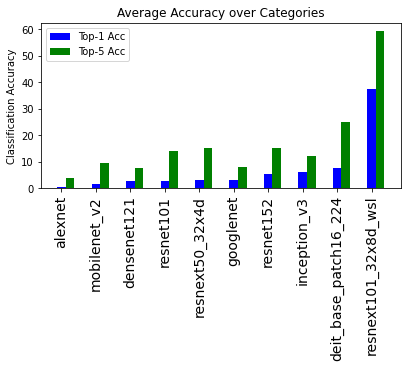

In [ ]:
X = np.arange(10)
fig = plt.figure(figsize=(5,2.3))

sortIdx = np.argsort(avgs_all,axis=0)[:,0]
avgs_all = avgs_all[sortIdx]
# ax = fig.add_axes(list(X))
ax = fig.add_axes([0,0,1,1])

ax.bar(X + 0.00, avgs_all[:,0], color = 'b', width = 0.25)
ax.bar(X + 0.25, avgs_all[:,1], color = 'g', width = 0.25)

ax.set_ylabel('Classification Accuracy')
ax.set_title('Average Accuracy over Categories')
ax.set_xticks(X)
ax.set_xticklabels(np.array(labels)[sortIdx], rotation=90, fontsize=14)
# ax.set_yticks(np.arange(0, 81, 10))
ax.legend(labels=['Top-1 Acc', 'Top-5 Acc'])

fig.show()

# plt.bar(avgs, height = 1, width=2)
# plt.bar(avgs[:,1], height=2, width=0.8)

In [ ]:
# sortIdx = np.argsort(avgs,axis=0)[:,0]
# avgs[sortIdx]


In [ ]:
# np.array(labels)[sortIdx]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


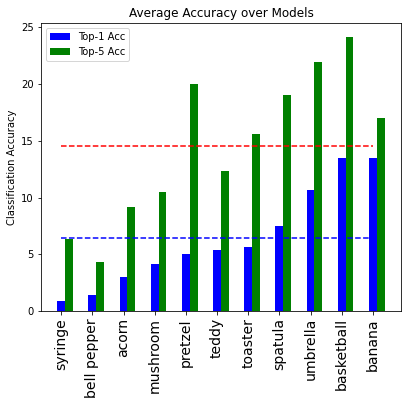

In [ ]:
# (top5_prob.data.tolist(), top5_catid.data.tolist())  

avgs_models = np.zeros((num_classes,2))

X = np.arange(num_classes)


# cat_labels = [str(i) for i in range(29)]

for i in range(9):
  a = np.array(list(perfs_acc[i].values()))
  avgs_models += a

avgs_models /= 10  

sortIdx = np.argsort(avgs_models,axis=0)[:,0]
avgs_models = avgs_models[sortIdx]

fig = plt.figure(figsize=(5,4))
ax = fig.add_axes([0,0,1,1])

ax.bar(X + 0.00, avgs_models[:,0], color = 'b', width = 0.25)
ax.bar(X + 0.25, avgs_models[:,1], color = 'g', width = 0.25)

ax.set_ylabel('Classification Accuracy')
ax.set_title('Average Accuracy over Models')
ax.set_xticks(X)
ax.set_xticklabels(np.array(dirs)[sortIdx], rotation=90, fontsize=14)
ax.legend(labels=['Top-1 Acc', 'Top-5 Acc'])


ax.plot(np.arange(num_classes), [avgs_models.mean(axis=0)[0]]*num_classes, color = 'b', linestyle='--')
ax.plot(np.arange(num_classes), [avgs_models.mean(axis=0)[1]]*num_classes, color = 'r', linestyle='--')


plt.tight_layout()
# plt.plot(a)
plt.show()

In [ ]:
(avgs_models).mean(axis=0)

array([ 6.42739392, 14.56659199])

In [ ]:
# perfs_acc

## Showing images

In [ ]:
# dirs
import numpy as np
import cv2

In [ ]:
# perfs = np.load('/content/drive/MyDrive/resultsNew.npy', allow_pickle=True)
# perfs = np.load('/content/drive/MyDrive/results.npy', allow_pickle=True)

In [ ]:
# perfs

In [ ]:
# pers = perfs.tolist()

In [ ]:
def resize_image(img, size=(200,200)):

    h, w = img.shape[:2]
    c = img.shape[2] if len(img.shape)>2 else 1

    if h == w: 
        return cv2.resize(img, size, cv2.INTER_AREA)

    dif = h if h > w else w

    interpolation = cv2.INTER_AREA if dif > (size[0]+size[1])//2 else cv2.INTER_CUBIC

    x_pos = (dif - w)//2
    y_pos = (dif - h)//2

    if len(img.shape) == 2:
        mask = np.ones((dif, dif), dtype=img.dtype) * 255
        mask[y_pos:y_pos+h, x_pos:x_pos+w] = img[:h, :w]
    else:
        mask = np.ones((dif, dif, c), dtype=img.dtype) * 255
        mask[y_pos:y_pos+h, x_pos:x_pos+w, :] = img[:h, :w, :]

    return cv2.resize(mask, size, interpolation)

In [ ]:
# perfs = pers
# perfs = [perfs]

In [ ]:
prob_top1[which_model][cat][f]
perfs[which_model][cat][f]
# perfs['clock']

('desk', ['desk', 'bookcase', 'file', 'desktop computer', 'binder'])

In [2]:
import cv2 

which_model = 0# 8
for cat in dirs:
  print(cat)
  isExist = os.path.exists(f'drive/MyDrive/{which_db}_Output/{cat}')

  if not isExist:
    os.makedirs(f'drive/MyDrive/{which_db}_Output/{cat}')

  # cat = 'kite'
  for f in perfs[which_model][cat]:
    
    if cat in perfs[which_model][cat][f][1]: continue # to mine only hard exampels

    indir = os.path.join(f'{which_db}/', cat)    
    img = cv2.imread(f'{indir}/{f}')

    img = resize_image(img)


    # top 1  
    label = perfs[which_model][cat][f][0]
    w = 20
    cv2.putText(img, label , (1, w),   fontFace = cv2.FONT_HERSHEY_COMPLEX, fontScale = .5, color = (0, 0, 255),  thickness = 2)
    cv2.putText(img, f'{prob_top1[which_model][cat][f].item():.3f}', (len(label)*12 + 10, w),   fontFace = cv2.FONT_HERSHEY_COMPLEX, fontScale = .5, color = (0, 0, 255),  thickness = 2)                      
    w += 20

    labels = perfs[which_model][cat][f][1][1:]
    for l in labels:
      cv2.putText(img, l , (1, w),   fontFace = cv2.FONT_HERSHEY_COMPLEX, fontScale = .5, color = (0, 0, 255),  thickness = 1)
      w += 20


    cv2.imwrite(f'drive/MyDrive/{which_db}_Output/{cat}/{f}', img)

    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    plt.show()
    


In [ ]:
labels

{'maze'}

In [ ]:
# set(perfs[9]['kite']['0001.jpeg'][1])
# img
# img
# perfs[which_model][cat]

In [ ]:
avg1 = []
avg2 = []

fig, axs = plt.subplots(10, 10, figsize=(30, 15), sharey=True, sharex=True)
plt.setp(axs, xticks=range(7), xticklabels=['1','4','7','10','13','16','19'])

for row in objects_freq:
  if len(objects_freq[row]) > 0:
    n1, n2 = row.split('_')
    n1, n2 = int(n1), int(n2)

    if n1 == n2:
      continue

    ob1, ob2 = [], []
    for key in [1,4,7,10,13,16,19]:
      o1, o2 = objects_freq[row][key]
      ob1.append(o1)
      ob2.append(o2)

    avg1.append(ob1)
    avg2.append(ob2)
    
    axs[n1][n2].plot(ob1)
    axs[n1][n2].plot(ob2)
    # axs[n1][n2].ticks([]) #range(7), ['1','4','7','10','13','16','19'])
    axs[n1][n2].set_title(objects[n1] + ' + '  + objects[n2])
    # axs[n1][n2].set_ylabel(objects[n1+1] + ' + '  + objects[n2+1])
    # plt.show()
fig.tight_layout()
plt.show()

# Dataset stats

In [ ]:
import os
import numpy as np
dirs = os.listdir('D2O/')

tot = 0
dd = {}
for folder in dirs:
  if '.' in folder: continue
  indir = os.path.join('./D2O/', folder)    
  files = os.listdir(indir)    

  dd[folder] = len(files)
  print(folder + ':' + str(len(files)))
  tot += len(files)

print(tot)

giraffe:139
bicycle-built-for-two:90
rabbit:323
vase:160
kite:128
cat:408
elephant:204
toilet seat:124
bell pepper:112
pillow:131
squirrel:151
miscellaneous:578
helmet:214
person:1218
pizza:144
banana:111
tractor:151
clock:184
bagel:114
turtle:232
pill bottle:110
basketball:120
car:540
mushroom:241
spatula:123
pretzel:123
toaster:138
mouse:136
face:290
syringe:122
sock:129
teddy:221
sunglass:119
acorn:152
umbrella:187
cow:393
8060


In [ ]:
ls D2O/ 

 acorn/                   cow/             person/         sunglass/
 bagel/                   elephant/       'pill bottle'/   syringe/
 banana/                  face/            pillow/         teddy/
 basketball/              giraffe/         pizza/          toaster/
'bell pepper'/            helmet/          pretzel/       'toilet seat'/
 bicycle-built-for-two/   kite/            rabbit/         tractor/
 car/                     miscellaneous/   sock/           turtle/
 cat/                     mouse/           spatula/        umbrella/
 clock/                   mushroom/        squirrel/       vase/


In [ ]:
X = sorted(dd.items(), key=lambda x:x[1])
s, t = zip(*X)

In [ ]:
s

('bicycle-built-for-two',
 'pill bottle',
 'banana',
 'bell pepper',
 'bagel',
 'sunglass',
 'basketball',
 'syringe',
 'spatula',
 'pretzel',
 'toilet seat',
 'kite',
 'sock',
 'pillow',
 'mouse',
 'toaster',
 'giraffe',
 'pizza',
 'squirrel',
 'tractor',
 'acorn',
 'vase',
 'clock',
 'umbrella',
 'elephant',
 'helmet',
 'teddy',
 'turtle',
 'mushroom',
 'face',
 'rabbit',
 'cow',
 'cat',
 'car',
 'miscellaneous',
 'person')

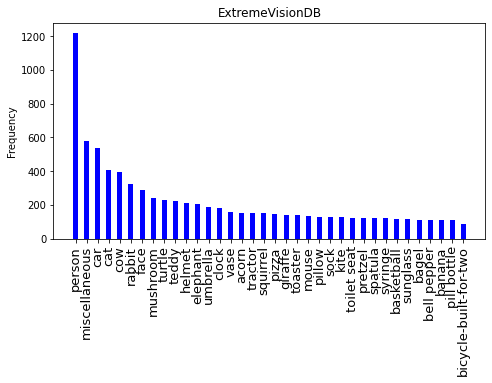

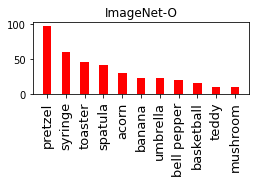

In [ ]:



# plt.bar(s,t)
fig = plt.figure(figsize=(6,3))
ax = fig.add_axes([0,0,1,1])
ax.bar(np.arange(len(s)) + 0.00, t[::-1], color = 'b', width = 0.45)
# ax.bar(np.arange(len(s)) + 0.25, ImageNet_O_idx, color = 'g', width = 0.25)


ax.set_xticks(np.arange(len(s)))
ax.set_xticklabels(s[::-1], rotation=90, fontsize=13)

ax.set_title('Distribution of number of ojects per category')
ax.set_title('ExtremeVisionDB')
ax.set_ylabel('Frequency')

plt.show()







ImageNet_O = {'acorn':23, 'banana':23, 'basketball':46,'bell pepper':42,'mushroom':98,'pretzel':10,'spatula':20,'syringe':11,'teddy':61,'toaster':16,'umbrella':31 }
# ImageNet_O_idx = [ImageNet_O.get(d,0) for d in s]
labels = [k for k in ImageNet_O.keys()]
nums = np.array(list(ImageNet_O.values()))
sortIdx = np.argsort(nums,axis=0)
nums = nums[sortIdx]


fig = plt.figure(figsize=(3,1))
ax = fig.add_axes([0,0,1,1])
ax.bar(np.arange(len(nums)) + 0.00, nums[::-1], color = 'r', width = 0.45)
# ax.bar(np.arange(len(s)) + 0.25, ImageNet_O_idx, color = 'g', width = 0.25)


ax.set_xticks(np.arange(len(nums)))
ax.set_xticklabels(np.array(labels)[sortIdx], rotation=90, fontsize=13)

ax.set_title('ImageNet-O')
# ax.set_ylabel('Frequency')

plt.show()

In [ ]:
labels

['acorn',
 'banana',
 'basketball',
 'bell pepper',
 'mushroom',
 'pretzel',
 'spatula',
 'syringe',
 'teddy',
 'toaster',
 'umbrella']